In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance as xgbplot
from lightgbm import LGBMClassifier
from lightgbm import plot_importance as lgbmplot
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [422]:
def get_clf_eval(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    print(f'정확도 : {round(accuracy, 3)} \n정밀도 : {round(precision, 3)} \n재현율 : {round(recall, 3)}, \nf1 score : {round(f1, 3)}, \nAUC : {round(auc, 3)}')

##### [과제] GBM을 하이퍼 파라미터 튜닝 하세요
---

In [ ]:
feature_name_df = pd.read_csv('../data/human_activity/features.txt', sep='\s+', header=None, \
                              names = ['column_index','column_name'])
# print(feature_name_df.head())
feature_name = feature_name_df.iloc[:,1].values.tolist()
# print(feature_name[:10])

feature_dup_df = feature_name_df.groupby('column_name').count()
# print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index() 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])
                                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('../data/human_activity/features.txt', sep='\s+', header=None, \
                              names = ['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv('../data/human_activity/train/X_train.txt', sep='\s+', header=None)
    X_train.columns = feature_name
    X_test = pd.read_csv('../data/human_activity/test/X_test.txt', sep='\s+', header=None)
    X_test.columns = feature_name
    
    y_train = pd.read_csv('../data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('../data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
pred = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도 :', round(accuracy, 3))
print(f'GBM 수행시간 :', time.time() - start_time)

NameError: name 'get_human_dataset' is not defined

##### [과제] 산탄데르 고객만족 데이터 세트에 대해서 고객만족 여부를 XGBoost와 LightGBM을 활용해 예측을 수행
---
- GridSearchCV도 사용해볼 것
- 독립변수 중요도 시각화

In [149]:
cust_df = pd.read_csv('../data/santander/train_santander.csv')

display(cust_df.head())
print(cust_df.info(), '\n')
print(cust_df.isnull().sum(), '\n')
print(cust_df.isnull().sum().sum())

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None 

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
                          ..
saldo_medio_var44_hace3    0
saldo_medio_var44_ult1     0
saldo_medio_var44_ult3     0
var38                      0
TARGET                     0
Length: 371, dtype: int64 

0


In [145]:
cust_df['TARGET'].value_counts(normalize = True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [146]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [147]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df1 = cust_df.drop('ID', axis = 1)

In [185]:
# 학습, 검증 세트 분리

X = cust_df1.iloc[:, :-1]
y = cust_df1['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0    0.960438
1    0.039562
Name: TARGET, dtype: float64
0    0.960405
1    0.039595
Name: TARGET, dtype: float64


In [412]:
# XGboost

evals = [(X_test, y_test)]
xgb_clf = XGBClassifier(n_estimators = 500, n_jobs = -1, tree_method ='gpu_hist', gpu_id=0, random_state = 156)
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = False)

pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

정확도 : 0.96 
정밀도 : 0.2 
재현율 : 0.002, 
f1 score : 0.003, 
AUC : 0.828


In [434]:
# XGboost gridsearch

xgb_clf1 = XGBClassifier(n_estimators = 100, random_state = 156, n_jobs = -1, tree_method ='gpu_hist', gpu_id=0)
params = {'max_depth': [5, 7],
          'min_child_weight': [1, 3],
          'colsample_bytree': [0.5, 0.75]}
gridcv = GridSearchCV(xgb_clf1, param_grid = params, cv = 3, n_jobs = -1)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'logloss', eval_set = evals, verbose = False)
# estimator = gridcv.best_estimator_
# gridpred = estimator.predict(X_test)
# gridpred_proba = estimator.predict_proba(X_test)[:, 1]
gridpred = gridcv.predict(X_test)
gridpred_proba = gridcv.predict_proba(X_test)[:, 1]

print('최적 파라미터 :', gridcv.best_params_)
get_clf_eval(y_test, gridpred, gridpred_proba)

최적 파라미터 : {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 3}
정확도 : 0.96 
정밀도 : 0.6 
재현율 : 0.005, 
f1 score : 0.01, 
AUC : 0.825


In [442]:
# XGboost 파라미터 수정

evals = [(X_test, y_test)]
xgb_clf = XGBClassifier(n_estimators = 1000, n_jobs = -1, tree_method ='gpu_hist', gpu_id=0, random_state = 156, colsample_bytree = 0.75, max_depth = 7, min_child_weight = 3)
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = False)

pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

정확도 : 0.96 
정밀도 : 0.6 
재현율 : 0.005, 
f1 score : 0.01, 
AUC : 0.825


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

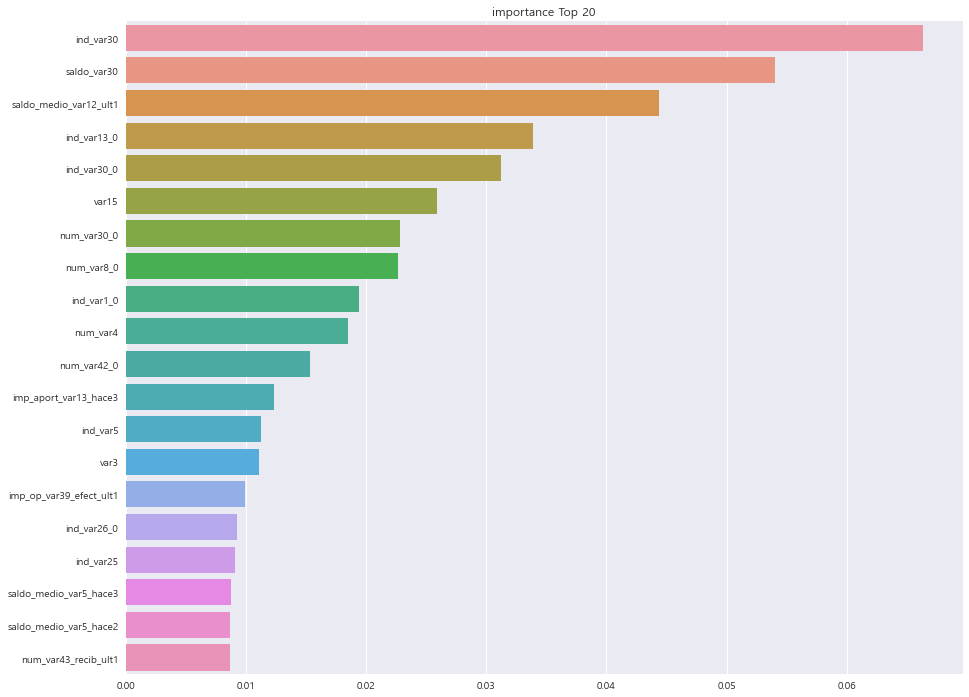

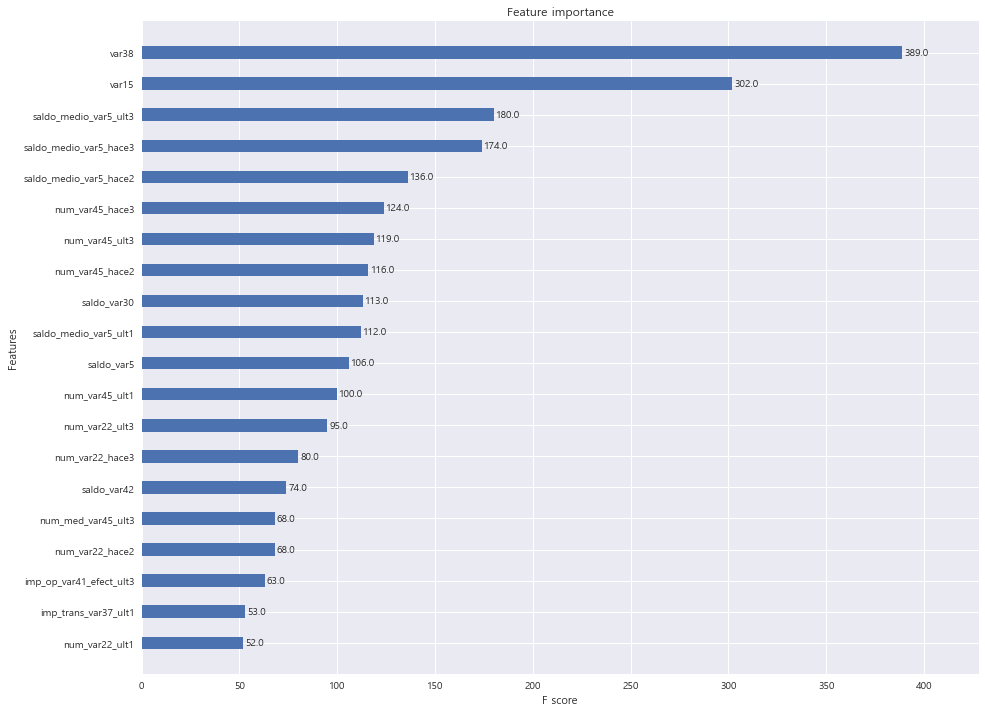

In [444]:
# xgboost 변수 중요도 시각화

importances = pd.Series(xgb_clf.feature_importances_, index = X_train.columns)
importances_top20 = importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (15, 12))
plt.title('importance Top 20')
sns.barplot(x = importances_top20, y = importances_top20.index)

fig, ax = plt.subplots(1, 1, figsize = (15, 12))
xgbplot(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

In [379]:
a = importances_top20.index

Index(['saldo_var30', 'var15', 'ind_var25_cte', 'num_var42_0',
       'imp_aport_var13_hace3', 'ind_var30', 'num_var39_0', 'ind_var13',
       'imp_op_var39_efect_ult1', 'ind_var9_ult1', 'num_var25_0',
       'saldo_var25', 'imp_op_var41_efect_ult3', 'ind_var8_0', 'ind_var41_0',
       'saldo_medio_var5_ult1', 'saldo_medio_var5_hace2',
       'imp_op_var39_efect_ult3', 'saldo_var37', 'var38'],
      dtype='object')

In [419]:
# LightGBM

evals = [(X_test, y_test)]
lgbm_clf = LGBMClassifier(n_estimators = 100, n_jobs = -1, random_state = 156)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 300, eval_metric = 'logloss', eval_set = evals, verbose = False)

pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

정확도 : 0.96 
정밀도 : 0.2 
재현율 : 0.002, 
f1 score : 0.003, 
AUC : 0.828


In [446]:
# LightGBM gridsearch

lgbm_clf1 = LGBMClassifier(n_estimators = 100, n_jobs = -1, random_state = 156)
params = {'num_leaves': [32, 64],
          'max_depth': [128, 160],
          'min_child_samples': [60, 100]}
gridcv1 = GridSearchCV(lgbm_clf1, param_grid = params, cv = 3, n_jobs = -1)
gridcv1.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'logloss', eval_set = evals, verbose = False)
# estimator = gridcv.best_estimator_
# gridpred = estimator.predict(X_test)
# gridpred_proba = estimator.predict_proba(X_test)[:, 1]
gridpred = gridcv.predict(X_test)
gridpred_proba = gridcv.predict_proba(X_test)[:, 1]

print('최적 파라미터 :', gridcv1.best_params_)
get_clf_eval(y_test, gridpred, gridpred_proba)

최적 파라미터 : {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32}
정확도 : 0.96 
정밀도 : 1.0 
재현율 : 0.002, 
f1 score : 0.003, 
AUC : 0.826


In [428]:
# LightGBM 파라미터 수정

evals = [(X_test, y_test)]
lgbm_clf = LGBMClassifier(n_estimators = 1000, n_jobs = -1, max_depth = 128, min_child_samples = 100, num_leaves = 32, random_state = 156)
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = False)

pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

정확도 : 0.96 
정밀도 : 0.2 
재현율 : 0.002, 
f1 score : 0.003, 
AUC : 0.828


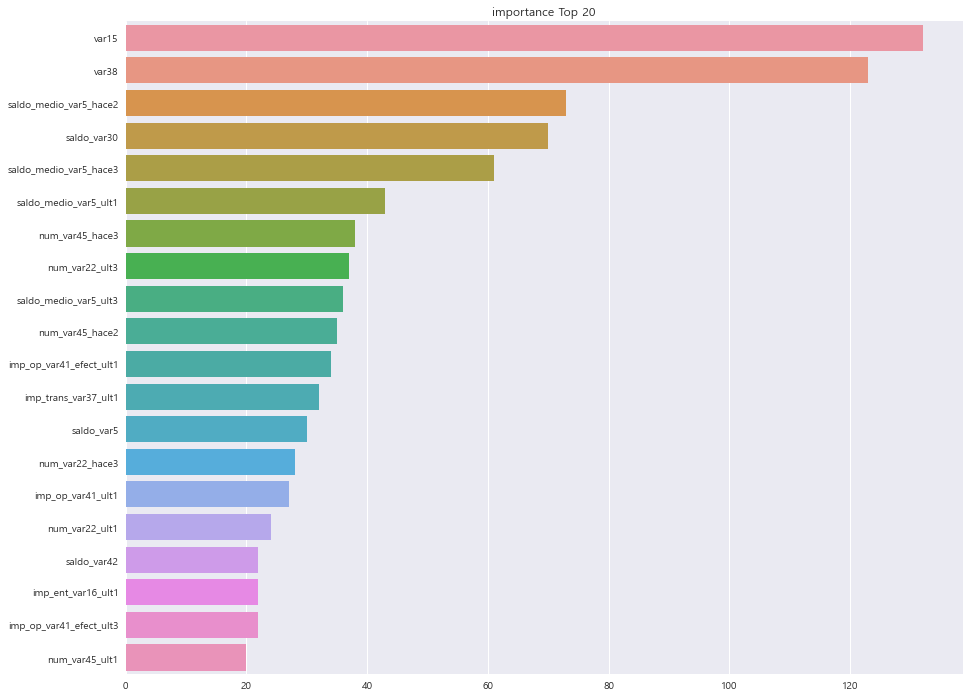

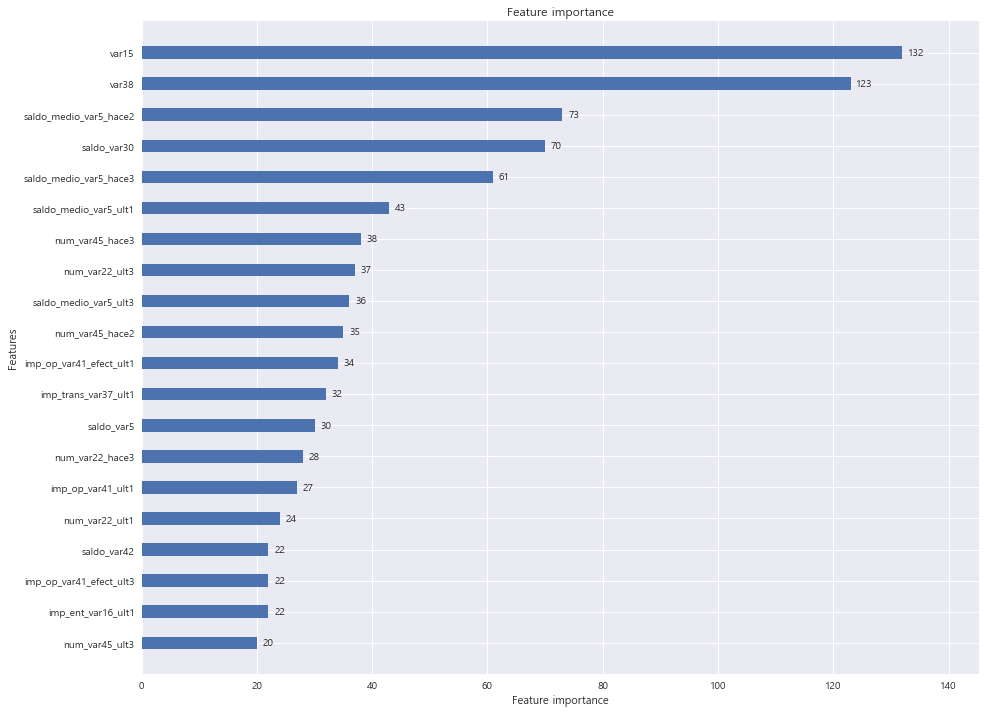

In [382]:
# LightGBM 변수 중요도 시각화

importances = pd.Series(lgbm_clf.feature_importances_, index = X_train.columns)
importances_top20 = importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (15, 12))
plt.title('importance Top 20')
sns.barplot(x = importances_top20, y = importances_top20.index)

fig, ax = plt.subplots(1, 1, figsize = (15, 12))
lgbmplot(lgbm_clf, ax = ax, max_num_features = 20, height = 0.4)
plt.show()

##### [과제] 캐글 신용카드 사기 검출
---
캐글 신용카드 거래내용이 포함된 데이터 셋을 아래 사이트에서 다운받아 다음 사항을 수행하세요.

https://www.kaggle.com/mlg-ulb/creditcardfraud
$$$$

<데이터 설명>

데이터 세트에는 유럽 카드 소지자가 2013년 9월에 신용 카드로 거래한 내용이 포함되어 있습니다. 이 데이터 세트는 284,807건의 거래 중 492건의 사기가 발생한 이틀 동안 발생한 거래를 보여줍니다. 데이터 세트는 매우 불균형하며 긍정적 클래스(사기)는 모든 거래의 0.172%를 차지합니다.

여기에는 PCA 변환의 결과인 숫자 입력 변수만 포함됩니다. 안타깝게도 기밀 문제로 인해 데이터에 대한 원래 기능과 추가 배경 정보를 제공할 수 없습니다. 기능 V1, V2, … V28은 PCA로 얻은 주요 구성 요소이며 PCA로 변환되지 않은 유일한 기능은 '시간'과 '양'입니다. 기능 '시간'에는 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 초가 포함됩니다. 'Amount' 기능은 거래 금액이며, 이 기능은 예제 종속 비용에 민감한 학습에 사용할 수 있습니다. 기능 'Class'는 응답 변수이며 사기의 경우 값 1, 그렇지 않은 경우 0을 취합니다.
$$$$

- 데이터 전처리 후 로지스틱 리그레션을 적용한 모델 학습 및 평가(정확도, 정밀도, 재현율, F1 score, AUC)
- Amount 피처를 정규분포 및 로그 변환 후 모델 학습 및 평가
- 상관성이 높은 피처 한개를 선택하여 이상치 데이터 제거 후 모델 학습 및 평가
- SMOTE 오버 샘플링 적용 후 모델 학습 및 평가
- SMOTE 적용 시 인사이트 요약

In [5]:
!pip install imbalanced-learn

In [450]:
card_df = pd.read_csv('../data/creditcard.csv')
display(card_df.head())
print(card_df.info())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [455]:
card_df['Class'].value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [545]:
# 학습, 검증 세트
def get_train_test(df):
    df1 = df.copy()
    df1.drop('Time', axis = 1, inplace = True)
    X = df1.iloc[:, :-1]
    y = df1.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 44, stratify = y)
    return X_train, X_test, y_train, y_test

# 예측/평가 수행
def get_model_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    print(f'오차행렬 : \n{confusion} \n\n정확도 : {round(accuracy, 3)} \n정밀도 : {round(precision, 3)} \n재현율 : {round(recall, 3)}, \nf1 score : {round(f1, 3)}, \nAUC : {round(auc, 3)}')
    
# 피쳐 스케일링
def get_scaled(method, df):
    df1 = df.copy()
    X = df1.iloc[:, :-1]
    if method == 'Standard':
        scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
    elif method == 'Log':
        scaled = np.log1p(X)
    else:
        scaled = X
    scaled_df = pd.concat([scaled, df1.iloc[:, -1]], axis = 1)
    return scaled_df

In [496]:
# 학습, 검증 세트 만들기

X_train, X_test, y_train, y_test = get_train_test(card_df)
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(85443, 85443)

In [503]:
# 로지스틱 회귀 평가
lr_clf = LogisticRegression(random_state = 44, n_jobs = -1)
get_model_eval(lr_clf, X_train, X_test, y_train, y_test)
print()

# LightGBM 평가
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False) # 본 경우와 같이 극도로 불균형한 분포를 이루는 경우 boost_from_average를 False로 설정해줘야 한다.
get_model_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬 : 
[[85273    22]
 [   57    91]] 

정확도 : 0.999 
정밀도 : 0.805 
재현율 : 0.615, 
f1 score : 0.697, 
AUC : 0.967


<AxesSubplot:xlabel='Amount', ylabel='Density'>

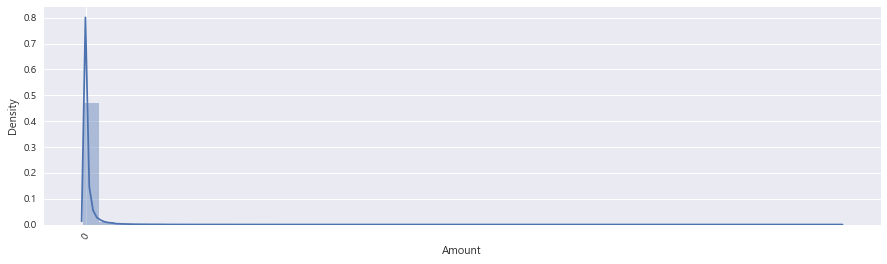

In [551]:
# amount 변환

from sklearn.preprocessing import StandardScaler

plt.figure(figsize = (15, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])
plt.show()

In [559]:
# Amount 표준화 후 평가

card_df1 = card_df.copy()
card_df1['Amount'] = get_scaled('Standard', card_df1)['Amount']
X_train, X_test, y_train, y_test = get_train_test(card_df1)

lr_clf = LogisticRegression(random_state = 44, n_jobs = -1)
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False, random_state = 44) # 본 경우와 같이 극도로 불균형한 분포를 이루는 경우 boost_from_average를 False로 설정해줘야 한다.

for i in [lr_clf, lgbm_clf]:
    print(i)
    get_model_eval(i, X_train, X_test, y_train, y_test)
    print()
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')

LogisticRegression(n_jobs=-1, random_state=44)
오차행렬 : 
[[85283    12]
 [   62    86]] 

정확도 : 0.999 
정밀도 : 0.878 
재현율 : 0.581, 
f1 score : 0.699, 
AUC : 0.974

LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=44)
오차행렬 : 
[[85290     5]
 [   28   120]] 

정확도 : 1.0 
정밀도 : 0.96 
재현율 : 0.811, 
f1 score : 0.879, 
AUC : 0.976



In [560]:
# Amount 로그변환 후 평가

card_df1 = card_df.copy()
card_df1['Amount'] = get_scaled('Log', card_df1)['Amount']
X_train, X_test, y_train, y_test = get_train_test(card_df1)

lr_clf = LogisticRegression(random_state = 44, n_jobs = -1)
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False, random_state = 44) # 본 경우와 같이 극도로 불균형한 분포를 이루는 경우 boost_from_average를 False로 설정해줘야 한다.

for i in [lr_clf, lgbm_clf]:
    print(i)
    get_model_eval(i, X_train, X_test, y_train, y_test)
    print()
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')

LogisticRegression(n_jobs=-1, random_state=44)
오차행렬 : 
[[85283    12]
 [   62    86]] 

정확도 : 0.999 
정밀도 : 0.878 
재현율 : 0.581, 
f1 score : 0.699, 
AUC : 0.971

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=44)
오차행렬 : 
[[85290     5]
 [   28   120]] 

정확도 : 1.0 
정밀도 : 0.96 
재현율 : 0.811, 
f1 score : 0.879, 
AUC : 0.976

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

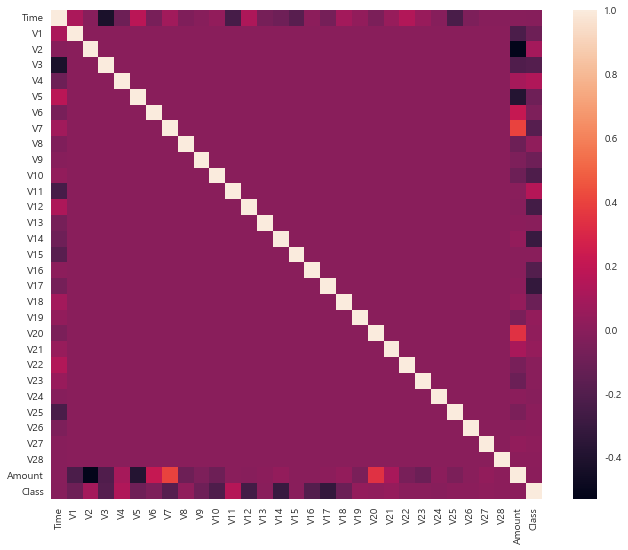

In [623]:
# 이상치 확인

plt.figure(figsize = (11, 9))
corr = card_df.corr()
sns.heatmap(corr)
corr['Class'].sort_values()

In [640]:
# 이상치 제거

card_df1 = card_df.copy()

for i in ['V14', 'V17']:
    fraud = card_df1[card_df1['Class'] == 1][i]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    lowest_val = quantile_25 - iqr * 1.5
    highest_val = quantile_75 + iqr * 1.5

    fraud_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    card_df1.drop(fraud_index, axis = 0, inplace = True)
print(len(card_df1), len(card_df))

284803 284807


In [641]:
# 이상치 제거 후 평가

card_df1['Amount'] = get_scaled('Log', card_df1)['Amount']
X_train, X_test, y_train, y_test = get_train_test(card_df1)

lr_clf = LogisticRegression(random_state = 44, n_jobs = -1)
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False, random_state = 44) # 본 경우와 같이 극도로 불균형한 분포를 이루는 경우 boost_from_average를 False로 설정해줘야 한다.

for i in [lr_clf, lgbm_clf]:
    print(i)
    get_model_eval(i, X_train, X_test, y_train, y_test)
    print()
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')

LogisticRegression(n_jobs=-1, random_state=44)
오차행렬 : 
[[85283    12]
 [   61    85]] 

정확도 : 0.999 
정밀도 : 0.876 
재현율 : 0.582, 
f1 score : 0.7, 
AUC : 0.976

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=44)
오차행렬 : 
[[85288     7]
 [   34   112]] 

정확도 : 1.0 
정밀도 : 0.941 
재현율 : 0.767, 
f1 score : 0.845, 
AUC : 0.97

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


In [643]:
# 오버 샘플링 적용 후 평가

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 44)
X_train, X_test, y_train, y_test = get_train_test(card_df)
# card_df1['Amount'] = get_scaled('Log', card_df1)['Amount']
# X_train, X_test, y_train, y_test = get_train_test(card_df1)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(len(X_train), len(y_train), len(X_train_over), len(y_train_over), '\n')

lr_clf = LogisticRegression(random_state = 44, n_jobs = -1)
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False, random_state = 44) # 본 경우와 같이 극도로 불균형한 분포를 이루는 경우 boost_from_average를 False로 설정해줘야 한다.

for i in [lr_clf, lgbm_clf]:
    print(i)
    get_model_eval(i, X_train_over, X_test, y_train_over, y_test)
    print()
    print('ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ')

199364 199364 398040 398040 

LogisticRegression(n_jobs=-1, random_state=44)
오차행렬 : 
[[83097  2198]
 [   13   135]] 

정확도 : 0.974 
정밀도 : 0.058 
재현율 : 0.912, 
f1 score : 0.109, 
AUC : 0.976

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
LGBMClassifier(boost_from_average=False, n_estimators=1000, num_leaves=64,
               random_state=44)
오차행렬 : 
[[85276    19]
 [   25   123]] 

정확도 : 0.999 
정밀도 : 0.866 
재현율 : 0.831, 
f1 score : 0.848, 
AUC : 0.968

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


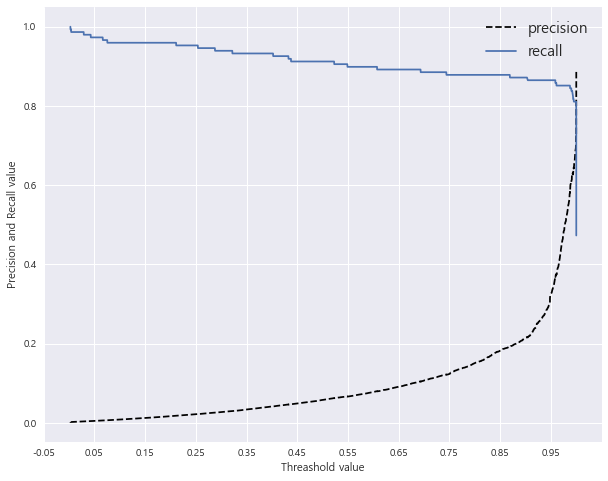

In [647]:
# 로지스틱 회귀 정밀도, 재현율 확인

from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize =(10, 8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], 'k--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threashold value'); plt.ylabel('Precision and Recall value')
    plt.legend(fontsize = 15)
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])